<center> 
<h1> Mehrgittermethoden </h1> 
<h2> Übungsaufgaben </h2>
<h3> Robert Speck & Dieter Moser, Sommersemester 2016 </h3>
</center>
___


### Das Helmholtz-Problem ###

1. Implementieren Sie das 1D Helmholtz-Problem $-\Delta u - \sigma u = 0$, $u(0) = u(1) = 0$ als neue Problem-Klasse. Dokumentieren Sie Ihren Code angemessen mit Hilfe des Sphinx-Frameworks. Nehmen Sie das Poisson-Problem als Vorlage.
1. Schreiben Sie ein Skript, welches für festes $h$ aber für verschiedene $\sigma\in[0,50]$ solange V-Zyklen  ausführt, bis eine Residuumstoleranz von $10^{-10}$ erreicht wird. Konvergiert der Mehrgitter-Algorithmus immer? Plotten Sie die Anzahl der Iterationen gegen $\sigma$ und interpretieren Sie das Ergebnis. 
1. Wählen Sie nun $\sigma\in[-50,0]$. Was stellen Sie fest?

Hinweis: Im `bin`-Ordner gibt die Datei `mg_poisson_test.py`, in dem der MG-Löser testweise aufgerufen wird. 

Erstellen Sie einen Release (welches auch das bearbeitete Notebook enthält) und reichen Sie den Link zum Release ein. Bei Einreichung wird dieses Notebook ausgeführt und erzeugt eine html-Version, die dann zur Korrektur genutzt wird. Achten Sie daher darauf, dass das Notebook ohne Fehler ausführbar ist und alle gewünschten Lösungen/Erklärungen enthält. 

sigma in [0, 50]:


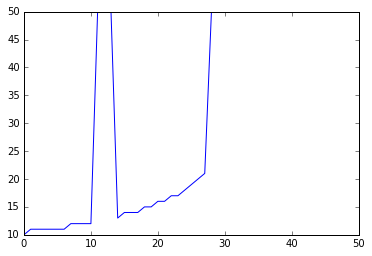

sigma in [-50, 0]


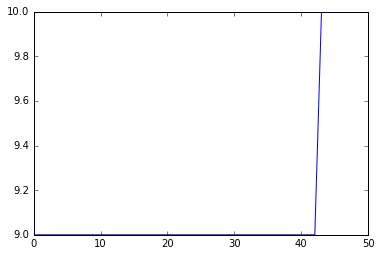

In [1]:
%matplotlib inline

import numpy as np
import scipy.linalg as LA
import scipy.sparse.linalg as spLA
import matplotlib.pyplot as plt

from project.poisson1d import Poisson1D
from project.helmholtz1d import Helmholtz1D
from project.weighted_jacobi import WeightedJacobi
# from project.gauss_seidel import GaussSeidel
from project.linear_transfer import LinearTransfer

from project.mymultigrid import MyMultigrid

ntests = 1
ndofs = 15
niter_list = []
for sigma in range(0, 51):
    for n in range(ntests):
        nlevels = int(np.log2(ndofs+1))
         
        prob = Helmholtz1D(ndofs=ndofs, sigma=sigma)

        mymg = MyMultigrid(ndofs=ndofs, nlevels=nlevels)
        mymg.attach_transfer(LinearTransfer)
        mymg.attach_smoother(WeightedJacobi,prob.A,omega=2.0/3.0)
        # mymg.attach_smoother(GaussSeidel,prob.A)
    
        k = 6
        xvalues = np.array([(i+1) * prob.dx for i in range(prob.ndofs)])
        prob.rhs = (np.pi*k)**2 * np.sin(np.pi*k*xvalues)
            
        uex = spLA.spsolve(prob.A, prob.rhs)
    
        res = 1
        niter = 0
        err = []
        u = np.zeros(uex.size)
        while res > 1E-10 and niter < 50:
            niter += 1
            u = mymg.do_v_cycle(u, prob.rhs, 2, 2, 0)
            res = LA.norm(prob.A.dot(u)-prob.rhs, np.inf)
            err.append(LA.norm(u-uex, np.inf))
            #print(niter,res,err[-1])
    
        niter_list.append(niter)

print('sigma in [0, 50]:')
plt.plot(niter_list)
plt.show()

niter_list = []
for sigma in range(-50, 0):
    for n in range(ntests):
        nlevels = int(np.log2(ndofs+1))
         
        prob = Helmholtz1D(ndofs=ndofs, sigma=sigma)

        mymg = MyMultigrid(ndofs=ndofs, nlevels=nlevels)
        mymg.attach_transfer(LinearTransfer)
        mymg.attach_smoother(WeightedJacobi,prob.A,omega=2.0/3.0)
        # mymg.attach_smoother(GaussSeidel,prob.A)
    
        k = 6
        xvalues = np.array([(i+1) * prob.dx for i in range(prob.ndofs)])
        prob.rhs = (np.pi*k)**2 * np.sin(np.pi*k*xvalues)
            
        uex = spLA.spsolve(prob.A, prob.rhs)
    
        res = 1
        niter = 0
        err = []
        u = np.zeros(uex.size)
        while res > 1E-10 and niter < 50:
            niter += 1
            u = mymg.do_v_cycle(u, prob.rhs, 2, 2, 0)
            res = LA.norm(prob.A.dot(u)-prob.rhs, np.inf)
            err.append(LA.norm(u-uex, np.inf))
            #print(niter,res,err[-1])
    
        niter_list.append(niter)

print('sigma in [-50, 0]')
plt.plot(niter_list)
plt.show()

### Der FMG-Zyklus ("Live-Aufgabe")###

Implementieren Sie entweder die rekursive oder die nicht-rekursive Version des FMG-Prediktors mit anschließenden V-Zyklen. Fügen Sie die Funktionalität in die `MyMultigrid`-Klasse ein. Stellen Sie die Entwicklung des Fehlers für das Poisson-Problem grafisch dar, indem Sie für jedes Level (z.B. nach der Grobgitter-Korrektur) den Fehler über die Freiheitsgrade plotten.

### Über zyklische Matrizen (Teil 1)
Sei $A$ von der Gestalt
$$A:=\begin{pmatrix} a_0&a_{n-1}&a_{n-2}&\ldots&a_1\\ a_1&a_0&a_{n-1}&\ldots&a_2\\ a_2&a_1&a_0&\ldots&a_3\\ &\ddots&\ddots&\ddots\\ a_{n-1}&a_{n-2}&a_{n-3}&\ldots&a_0\end{pmatrix}. $$

1. Berechnen Sie das charakteristische Polynom, die Eigenwerte, Eigenvektoren und die Determinante von $A$.
1. Seien $B$ und $C$ zyklische miteinander kommutierende Matrizen mit den Eigenwerten $\{\beta_k\},\{\zeta_k\}$.
   Was sind die Eigenwerte von $BC$.
1. Zeigen Sie, dass der Raum der zyklischen Matrizen ein Untervektorraum des $K^{N \times N}$


### Fourier Reihen 

Sei $\{t_k\}_{-\infty}^{\infty}$ eine absolut summierbare Folge, d.h. $\sum_{k=-\infty}^{\infty}|t_k| < \infty$.
Sei desweiteren $f(\lambda) = \lim_{n \to \infty} \sum_{k=-n}^{n}t_k e^{ik\lambda}$.

1. Zeigen Sie, dass $S_n(\lambda) = \sum_{k=-n}^{n}t_k e^{ik\lambda}$ gleichmässig gegen $f(\lambda)$ konvergiert.
1. Folgern Sie, dass $f(\lambda)$ Riemann-integrierbar und beschränkt auf $[0,2\pi]$ ist.
1. Finden Sie mithilfe der inversen Fouriertransformation eine Darstellung von $t_k$ unter Verwendung von $f(\lambda)$.

Wir nennen $f(\lambda)$ eine Funktion der *Wiener Klasse*.
